### Open File

In [110]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [111]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [112]:
df = df.dropna(subset=['Dist_Center'])

### Create Predicted Category for final models (2 categories)

In [113]:
diff_hotels = df[['Hotel_Address','Diff']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff.reset_index()

In [114]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [115]:
category = np.array(['Bad' if i < 7 else 'Good' for i in df.Reviewer_Score])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df)

Good    0.831582
Bad     0.168418
Name: Category, dtype: float64

### Select Bad Reviews & Category to Analyze

In [116]:
df_original = df.copy()

In [117]:
df =  df_original[df_original.Category=="Bad"]

In [118]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng', 'Diff', 'Diff_Percentage',
       'Review_Month', 'Review_Year', 'Country', 'City', 'Pet', 'Purpose',
       'Whom', 'Room', 'Length', 'Device', 'Room_Recode', 'Nationality_Recode',
       'Length_Recode', 'Close_Landmarks', 'Dist_Center', 'Dist_Airport',
       'Dist_Train', 'Price', 'Stars', 'Length_N', 'Reservation_ADR',
       'food_Neg', 'staff_Neg', 'location_Neg', 'value_Neg', 'comfort_Neg',
       'room_Neg', 'facilities_Neg', 'cleanliness_Neg', 'food_Pos',
       'staff_Pos', 'location_Pos', 'value_Pos', 'comfort_Pos', 'room_Pos',
       'facilities_Pos', 'cleanliness_Pos', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'loca

In [120]:
df.Category = df.cleanliness_Neg

### Balance Nationalities and / or Categories

In [121]:
def balance_df(df, Balance_Nationality, Balance_Category, cut):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = cut
            if len(nationality) < n:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [122]:
df_balanced_1 = balance_df(df, Balance_Nationality=False, Balance_Category=True, cut=10000)
df_balanced_2 = balance_df(df_balanced_1, Balance_Nationality=True, Balance_Category=True, 
                         cut=int(np.median(df_balanced_1.Nationality_Recode.value_counts())*1.5))
df_balanced_2.shape

(10988, 78)

In [123]:
df_balanced_2.Nationality_Recode.value_counts()

Middle east            1711
UK & Ireland           1708
Western Europe         1707
North America          1556
Eastern Europe         1517
Asia & Pacific         1145
Oceania                 847
Sub-Saharian Africa     289
South/Latin America     232
Arab States             143
China                   133
Name: Nationality_Recode, dtype: int64

### Prepare Data to run Models

In [124]:
if len(df_balanced_2) > 20000:
    df_model = df_balanced_2.sample(n=20000, random_state=1)
else:
    df_model = df_balanced_2.copy()

df_model.shape

(10988, 78)

In [125]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [126]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [127]:
df_model['Review_Month'] = df_model['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [128]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [129]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [130]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((5494, 77), (5494,), (5494, 77), (5494,))

## MODELS

### Evaluate Model

In [131]:
import time
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials, space_eval

In [132]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [133]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [134]:
def evaluate_grid(model, params, X_train, X_test, y_train, y_test, verbose = 1):
    f1 = make_scorer(f1_score, pos_label = 1)
    H = make_scorer(H_score, greater_is_better=True) 
    clf = GridSearchCV(estimator = model, param_grid = params, n_jobs = -1, cv = 5, verbose = verbose)    
    clf.fit(X_train, y_train)
    print(clf.best_params_, clf.best_score_)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [135]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label=1):.4f}',
          '| Precision Test :', f'{precision_score(clf.predict(X_test), y_test, pos_label=1):.4f}', 
          '| H Test :', f'{H_score(clf.predict(X_test), y_test):.4f}')
    
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label=1):.4f}',
          '| Precision Train:', f'{precision_score(clf.predict(X_train), y_train, pos_label=1):.4f}', 
          '| H Train:', f'{H_score(clf.predict(X_train), y_train):.4f}')

In [136]:
def H_score(X_train, y_train):
    acc = accuracy_score(X_train, y_train)
    f1 = f1_score(X_train, y_train, pos_label = 1)
    return(2 / ((1/acc)+(1/f1)))

In [137]:
def bayesian(space, X, y, modelo, nevals):
    
    H = make_scorer(H_score, greater_is_better=True) 
        
    def objective(space):
        
        global best_score
        
        model = modelo(**space)   
        kfold = KFold(n_splits=5, random_state=1985, shuffle=True)
        score = -cross_val_score(model, X, y, cv=kfold, scoring='accuracy', verbose=False).mean()
        if (score < best_score):
            best_score = score
        return score

    start = time.time()

    best = fmin(
      objective, 
      space = space,
      algo = tpe.suggest, 
      max_evals = nevals,
      trials = Trials())

    print("Hyperopt search took %.2f seconds for 200 candidates" % ((time.time() - start)))
    print("Best score: %.4f " % (-best_score))
    print("Best space: ", space_eval(params, best))
    return(space_eval(params, best))

### KNN

In [141]:
pred_knn = evaluate_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test)

Accuracy Test : 0.5453 | F1 Test : 0.5461 | Precision Test : 0.5471 | H Test : 0.5457
Accuracy Train: 0.6993 | F1 Train: 0.6994 | Precision Train: 0.6997 | H Train: 0.6994


### Gradient Boosted Trees

In [142]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 
                                                          0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.50]), 
          'n_estimators':      hp.choice('n_estimators', range(1,400)),
          'max_depth':         hp.choice('max_depth',range(1,20)),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train, y_train, GradientBoostingClassifier, 50)
pred_gbt = evaluate_model(GradientBoostingClassifier(**gbt_params), X_train, X_test, y_train, y_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:02<00:00,  4.85s/trial, best loss: -0.573714139862203]
Hyperopt search took 242.51 seconds for 200 candidates
Best score: 0.5737 
Best space:  {'learning_rate': 0.05, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 0.32, 'min_samples_split': 0.01, 'n_estimators': 248, 'subsample': 1}
Accuracy Test : 0.5817 | F1 Test : 0.5855 | Precision Test : 0.5908 | H Test : 0.5836
Accuracy Train: 0.5914 | F1 Train: 0.5977 | Precision Train: 0.6072 | H Train: 0.5945


### Random Forest

In [143]:
params = {'bootstrap':         hp.choice('bootstrap',[True, False]),
          'max_depth':         hp.choice('max_depth', range(1, 20)),
          'max_features':      hp.choice('max_features',['auto', 'sqrt']),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'n_estimators':      hp.choice('n_estimators',range(1,400))}

best_score = 1
rf_params = bayesian(params, X_train, y_train, RandomForestClassifier, 50)
pred_rf = evaluate_model(RandomForestClassifier(**rf_params), X_train, X_test, y_train, y_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:31<00:00,  5.43s/trial, best loss: -0.572076950232949]
Hyperopt search took 271.51 seconds for 200 candidates
Best score: 0.5721 
Best space:  {'bootstrap': True, 'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 0.06999999999999999, 'min_samples_split': 0.09999999999999999, 'n_estimators': 50}
Accuracy Test : 0.5763 | F1 Test : 0.5858 | Precision Test : 0.5992 | H Test : 0.5810
Accuracy Train: 0.5896 | F1 Train: 0.5941 | Precision Train: 0.6007 | H Train: 0.5918


### XGBoosting

In [144]:
params = {'learning_rate':    hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                                         0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', range(1,200))}

best_score = 1
xgb_params = bayesian(params, X_train, y_train, xgb.XGBClassifier, 50)
pred_xgb = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [17:41<00:00, 21.23s/trial, best loss: -0.5808134899917295]
Hyperopt search took 1061.86 seconds for 200 candidates
Best score: 0.5808 
Best space:  {'colsample_bytree': 0.49, 'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 0.61, 'n_estimators': 80}
Accuracy Test : 0.5861 | F1 Test : 0.5999 | Precision Test : 0.6207 | H Test : 0.5929
Accuracy Train: 0.6085 | F1 Train: 0.6194 | Precision Train: 0.6371 | H Train: 0.6139


### Logistic Regresion

In [138]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]),
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 
                                  0.05, 0.1])}

best_score = 1
log_params = bayesian(params, X_train, y_train, LogisticRegression, 50)
pred_log = evaluate_model(LogisticRegression(**log_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.05trial/s, best loss: -0.5866377945839155]
Hyperopt search took 16.39 seconds for 200 candidates
Best score: 0.5866 
Best space:  {'C': 0.01, 'tol': 0.0001}
Accuracy Test : 0.6008 | F1 Test : 0.5854 | Precision Test : 0.5635 | H Test : 0.5930
Accuracy Train: 0.6043 | F1 Train: 0.5872 | Precision Train: 0.5628 | H Train: 0.5956


### Decision Trees

In [139]:
iterations = 100
params = {"max_depth":        hp.choice('max_depth', range(1, 20)),
          "max_features":     hp.choice('max_features', range(1, 50)),
          "min_samples_leaf": hp.choice('min_samples_leaf', range(1, 50)),
          "criterion":        hp.choice('criterion', ["gini", "entropy"])}

best_score = 1
tree_params = bayesian(params, X_train, y_train, DecisionTreeClassifier, 150)
pred_tree = evaluate_model(DecisionTreeClassifier(**tree_params), X_train, X_test, y_train, y_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:44<00:00,  3.37trial/s, best loss: -0.5689800795888298]
Hyperopt search took 44.52 seconds for 200 candidates
Best score: 0.5690 
Best space:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 37, 'min_samples_leaf': 13}
Accuracy Test : 0.5783 | F1 Test : 0.6476 | Precision Test : 0.7750 | H Test : 0.6110
Accuracy Train: 0.5688 | F1 Train: 0.6391 | Precision Train: 0.7637 | H Train: 0.6019


### SVM

In [145]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train, y_train, SVC, 10)
pred_svm = evaluate_model(SVC(**svm_params), X_train, X_test, y_train, y_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:56<00:00, 23.67s/trial, best loss: -0.562249503191343]
Hyperopt search took 236.74 seconds for 200 candidates
Best score: 0.5622 
Best space:  {'C': 0.25, 'degree': 2, 'kernel': 'poly'}
Accuracy Test : 0.5701 | F1 Test : 0.5752 | Precision Test : 0.5821 | H Test : 0.5726
Accuracy Train: 0.6176 | F1 Train: 0.6196 | Precision Train: 0.6229 | H Train: 0.6186


### Naive Bayes

In [140]:
params = {"alpha":     hp.choice('alpha', [0.025, 0.05, 0.075, 0.1, 0.15, 0.20, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 
                                           2, 2.5, 5, 10]), 
          "fit_prior": hp.choice('fit_prior', [True, False])}

best_score = 1
nb_params = bayesian(params, X_train, y_train, BernoulliNB, 50)
pred_nb = evaluate_model(BernoulliNB(**nb_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  5.64trial/s, best loss: -0.5666161156607016]
Hyperopt search took 8.88 seconds for 200 candidates
Best score: 0.5666 
Best space:  {'alpha': 0.75, 'fit_prior': False}
Accuracy Test : 0.5792 | F1 Test : 0.5779 | Precision Test : 0.5763 | H Test : 0.5786
Accuracy Train: 0.5770 | F1 Train: 0.5748 | Precision Train: 0.5719 | H Train: 0.5759


## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [146]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [147]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [148]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
113744,1,1,1,1,1,1,1,1
79720,0,1,1,1,1,0,1,1


In [149]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [150]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Gradient Boosting Trees

In [151]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 
                                                          0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.50]), 
          'n_estimators':      hp.choice('n_estimators', range(1,400)),
          'max_depth':         hp.choice('max_depth',range(1,20)),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train_2, y_train_2, GradientBoostingClassifier, 50)
pred_gbt_stck = evaluate_model(GradientBoostingClassifier(**gbt_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:20<00:00,  6.41s/trial, best loss: -0.5936291240045506]
Hyperopt search took 320.42 seconds for 200 candidates
Best score: 0.5936 
Best space:  {'learning_rate': 0.25, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 0.03, 'min_samples_split': 0.89, 'n_estimators': 140, 'subsample': 1}
Accuracy Test : 0.5569 | F1 Test : 0.5694 | Precision Test : 0.5781 | H Test : 0.5631
Accuracy Train: 0.6337 | F1 Train: 0.6309 | Precision Train: 0.6283 | H Train: 0.6323


### XGB

In [154]:
params = {'learning_rate':    hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                                         0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', range(1,200))}

best_score = 1
xgb_params = bayesian(params, X_train_2, y_train_2, xgb.XGBClassifier, 50)
pred_xgb_stck = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [28:21<00:00, 34.02s/trial, best loss: -0.5902161547212741]
Hyperopt search took 1701.42 seconds for 200 candidates
Best score: 0.5902 
Best space:  {'colsample_bytree': 0.89, 'gamma': 0.61, 'learning_rate': 0.075, 'max_depth': 2, 'min_child_weight': 0.89, 'n_estimators': 153}
Accuracy Test : 0.5532 | F1 Test : 0.5659 | Precision Test : 0.5745 | H Test : 0.5595
Accuracy Train: 0.6494 | F1 Train: 0.6492 | Precision Train: 0.6511 | H Train: 0.6493


### SVM

In [45]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train_2, y_train_2, SVC, 10)
pred_svm_stck = evaluate_model(SVC(**svm_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [04:35<00:00, 27.54s/trial, best loss: -0.65575]
Hyperopt search took 275.40 seconds for 200 candidates
Best score: 0.6558 
Best space:  {'C': 0.075, 'degree': 2, 'kernel': 'poly'}
Accuracy Test : 0.6515 | F1 Test : 0.6720 | Precision Test : 0.7361 | H Test : 0.6616
Accuracy Train: 0.6596 | F1 Train: 0.6850 | Precision Train: 0.7288 | H Train: 0.6721


### Logistic Regression

In [152]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 
                                0.075, 0.1]),
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.000075, 0.0001, 0.00025, 0.0005, 0.00075, 
                                  0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1])}

best_score = 1
log_params = bayesian(params, X_train_2, y_train_2, LogisticRegression, 50)
pred_log_stck = evaluate_model(LogisticRegression(**log_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.30trial/s, best loss: -0.595221843003413]
Hyperopt search took 21.74 seconds for 200 candidates
Best score: 0.5952 
Best space:  {'C': 0.075, 'tol': 0.025}
Accuracy Test : 0.5705 | F1 Test : 0.5564 | Precision Test : 0.5314 | H Test : 0.5634
Accuracy Train: 0.6180 | F1 Train: 0.6011 | Precision Train: 0.5776 | H Train: 0.6094


### Decision Trees

In [153]:
iterations = 100
params = {"max_depth":        hp.choice('max_depth', range(1, 20)),
          "max_features":     hp.choice('max_features', range(1, 50)),
          "min_samples_leaf": hp.choice('min_samples_leaf', range(1, 50)),
          "criterion":        hp.choice('criterion', ["gini", "entropy"])}

best_score = 1
tree_params = bayesian(params, X_train_2, y_train_2, DecisionTreeClassifier, 150)
pred_tree_stck = evaluate_model(DecisionTreeClassifier(**tree_params), X_train_2, X_test_2, y_train_2, y_test_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68trial/s, best loss: -0.5856655290102389]
Hyperopt search took 40.86 seconds for 200 candidates
Best score: 0.5857 
Best space:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 41, 'min_samples_leaf': 35}
Accuracy Test : 0.5541 | F1 Test : 0.6293 | Precision Test : 0.7469 | H Test : 0.5894
Accuracy Train: 0.5868 | F1 Train: 0.6506 | Precision Train: 0.7721 | H Train: 0.6171


In [52]:
pd.crosstab(pred_log_stck, y_test_2)

Category,Bad,Good
row_0,,
Bad,657,357
Good,313,673


## BACKWARD ELIMINATION

In [55]:
import random
from random import sample

In [56]:
def try_seed(seed, verbose=True):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          end='\r', flush=True)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', f'{score:.4f}','                                                                       ')
            return(varin, score)
            break

### XGB

In [59]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = xgb.XGBClassifier(**xgb_params, random_state=1)            
    clf.fit(X_train, y_train)
    score = accuracy_score(clf.predict(X_train), y_train)
    return(variable, score)

In [60]:
max_score = 0
var_selec = []
for seed in range(4):
    varin, score = try_seed(seed, verbose=True)
    if score > max_score:
        max_score = score
        var_selec = varin

Seed: 0 <- 0.6760                                                                        
Seed: 1 <- 0.6765                                                                        
Seed: 2 <- 0.6757                                                                        
Seed: 3 <- 0.6796                                                                        


In [65]:
X_train_varin = X_train_2[var_selec]
X_test_varin = X_test_2[var_selec] 

X_train_varin = X_train_2
X_test_varin = X_test_2

clf = xgb.XGBClassifier(**xgb_params, random_state=1)            
clf.fit(X_train_varin, y_train_2)
print("F1-Score: ", f1_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Accuracy: ", accuracy_score(clf.predict(X_test_varin), y_test_2))
print("Recall:   ", recall_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("Precision:", precision_score(clf.predict(X_test_varin), y_test_2, pos_label='Bad'))
print("H-Score  :", H_score(clf.predict(X_test_varin), y_test_2))

F1-Score:  0.6623634558093345
Accuracy:  0.66
Recall:    0.6388888888888888
Precision: 0.6876288659793814
H-Score  : 0.661179615806311


In [66]:
pd.crosstab(clf.predict(X_test_varin), y_test_2)

Category,Bad,Good
row_0,,
Bad,667,377
Good,303,653


## CONFIDENCE INTERVAL

In [68]:
pred_f1 = []
pred_ac = []
pred_H = []

for i in range(1000):
    sample = np.random.randint(0, len(X_test_varin), size=len(X_test_varin))
    X_sample = X_test_varin.iloc[sample]
    y_sample = y_test_2.iloc[sample]
    print(i, end='\r', flush=True)
    pred_f1.append(f1_score(clf.predict(X_sample), y_sample, pos_label='Bad'))
    pred_ac.append(accuracy_score(clf.predict(X_sample), y_sample))
    pred_H.append(H_score(clf.predict(X_sample), y_sample))

(array([ 3.,  4.,  6., 13., 20., 27., 39., 57., 61., 61., 90., 88., 90.,
        95., 88., 74., 56., 44., 29., 25., 10.,  7.,  6.,  4.,  3.]),
 array([0.62925852, 0.63200143, 0.63474434, 0.63748725, 0.64023017,
        0.64297308, 0.64571599, 0.6484589 , 0.65120182, 0.65394473,
        0.65668764, 0.65943055, 0.66217347, 0.66491638, 0.66765929,
        0.6704022 , 0.67314511, 0.67588803, 0.67863094, 0.68137385,
        0.68411676, 0.68685968, 0.68960259, 0.6923455 , 0.69508841,
        0.69783133]),
 <a list of 25 Patch objects>)

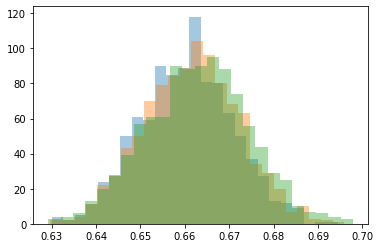

In [71]:
plt.hist(pred_ac, bins=25, alpha=0.4)
plt.hist(pred_H, bins=25, alpha=0.4)
plt.hist(pred_f1, bins=25, alpha=0.4)

In [72]:
print('            2.5%    50%  97.5%')
print('H-Score: ',f'{np.percentile(pred_H, 2.5):.4f}',f'{np.percentile(pred_H, 50):.4f}',f'{np.percentile(pred_H, 97.5):.4f}')
print('Accuracy:',f'{np.percentile(pred_ac,2.5):.4f}',f'{np.percentile(pred_ac,50):.4f}',f'{np.percentile(pred_ac,97.5):.4f}')
print('F1-Score:',f'{np.percentile(pred_f1,2.5):.4f}',f'{np.percentile(pred_f1,50):.4f}',f'{np.percentile(pred_f1,97.5):.4f}')

            2.5%    50%  97.5%
H-Score:  0.6417 0.6619 0.6822
Accuracy: 0.6405 0.6605 0.6810
F1-Score: 0.6402 0.6633 0.6858
